In [1]:
!pip install --user -q ktext
!pip install --user  -q annoy
!pip install --user  tensorflow_hub

In [1]:
import json
from urllib.request import urlopen

from annoy import AnnoyIndex
from tensorflow.python.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda, BatchNormalization
from tensorflow.python.keras.models import load_model, Model
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.utils import get_file, to_categorical
from ktext.preprocess import processor
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
# get training data

# data = pd.read_csv('final_recipes.csv')
data = pd.read_csv('final_two.csv')
# data = data.replace(to_replace= ["[","'","]"], value= '', regex=True)


In [4]:
data.dropna(inplace=True)
data['ingredients'] = data['ingredients'].apply(lambda x: x.replace("[","").replace("'","").replace("]","").replace(" , ","").replace(",,,,,,","").replace(",,","").replace(",,,","").replace(",,,,","").replace(",,,,,",""))
data['name'] = data['name'].apply(lambda x: x.replace('  ',' ').replace('  ',' '))

In [6]:
data['name'].head(40)

0              arriba baked winter squash mexican style
1                       a bit different breakfast pizza
2                              all in the kitchen chili
3                                     alouette potatoes
4                      amish tomato ketchup for canning
5                                apple a day milk shake
6                                  aww marinated olives
7                         backyard style barbecued ribs
8                               bananas 4 ice cream pie
9                                beat this banana bread
10                           berry good sandwich spread
11                         better than sex strawberries
12                       better then bush s baked beans
13                            boat house collard greens
14                               calm your nerves tonic
15                       chicken lickin good pork chops
16                                       chile rellenos
17                                        chines

In [6]:
from sklearn.model_selection import train_test_split

#target - recipe name
#source = ingredients
source_docs = data['ingredients'].tolist()
target_docs = data['name'].tolist()

# source_docs_t = data['ingredients'].sample(2000, random_state=7).tolist()
# target_docs_t = data['name'].sample(2000, random_state=7).tolist()

train_source_docs, test_source_docs, train_target_docs, test_target_docs = train_test_split(source_docs, target_docs, test_size=0.33, random_state=42)

for i in range(len(train_source_docs)):
    train_source_docs[i] = train_source_docs[i].replace("'","").replace("  "," ").replace("[","").replace("]","").replace(" ,","")

test_docs = pd.Series(test_target_docs).sample(10000).tolist()



In [7]:
# len(test_docs)
# test_docs
# train_source_docs
# train_target_docs

In [8]:
#processor adds padding to all text entries in order to make all inputs the same length
proc = processor(heuristic_pct_padding=.95, keep_n=10000)
vecs = proc.fit_transform(target_docs)



 See full histogram by insepecting the `document_length_stats` attribute.


In [9]:
# proc.token_count_pandas().head(20)

In [10]:
proc.document_length_stats

,bin,doc_count,cumsum_pct
1,0,25419,0.109737
0,5,191905,0.938213
2,10,14253,0.999745
3,15,59,1.000000


In [11]:
assert vecs.shape[0] == len(target_docs)

In [12]:
print('original list: ', target_docs[0])
print('tokenized list: ', vecs[0])

original list:  arriba baked winter squash mexican style
tokenized list:  [   0    0    0    0 7897   22  587  121  106   45]


In [13]:
vocab_size = max(proc.id2token.keys()) + 1
max_length = proc.padding_maxlen

print('vocab size: ', vocab_size)
print('max length allowed for documents: ', max_length)

vocab size:  10002
max length allowed for documents:  10


In [14]:
sequences = []
for arr in tqdm(vecs):
    non_zero = (arr != 0).argmax()
    for i in range(non_zero, len(arr)):
        sequences.append(arr[:i+1])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
# y = to_categorical(y, num_classes=vocab_size)

100%|██████████| 231636/231636 [00:00<00:00, 262253.11it/s]


In [15]:
i = Input(shape=(max_length-1,))
x = Embedding(vocab_size, 256, input_length=max_length-1)(i)
x = LSTM(256, return_sequences=True)(x)
last_timestep = Lambda(lambda x: x[:, -1, :])(x)
last_timestep = Dense(vocab_size, activation='softmax')(last_timestep)
model = Model(i, last_timestep)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 9, 256)            2560512   
_________________________________________________________________
lstm (LSTM)                  (None, 9, 256)            525312    
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10002)             2570514   
Total params: 5,656,338
Trainable params: 5,656,338
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=15, batch_size=256, validation_split=0.2)

Train on 809378 samples, validate on 202345 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
809378/809378 [==============================] - 211s 260us/sample - loss: 5.8571 - acc: 0.1316 - val_loss: 6.2881 - val_acc: 0.1648
Epoch 2/15
809378/809378 [==============================] - 209s 258us/sample - loss: 5.0931 - acc: 0.1927 - val_loss: 6.2245 - val_acc: 0.1837
Epoch 3/15
809378/809378 [==============================] - 207s 256us/sample - loss: 4.8412 - acc: 0.2079 - val_loss: 6.3688 - val_acc: 0.1890
Epoch 4/15
809378/809378 [==============================] - 206s 254us/sample - loss: 4.6768 - acc: 0.2177 - val_loss: 6.4310 - val_acc: 0.1901
Epoch 5/15
809378/809378 [==============================] - 203s 251us/sample - loss: 4.5494 - acc: 0.2264 - val_loss: 6.5481 - val_acc: 0.1886
Epoch 6/15
809378/809378 [==============================] - 203s 250us/sample - loss: 4.4432 - acc: 0.2356 - val_loss: 6.5762 - val_acc: 0.1869
Epoch 7/15
809378/809378 [==============================] - 206s 255us/sample - loss: 4.3516 - acc: 0.2441 - val_loss: 6.7245 - val_acc:

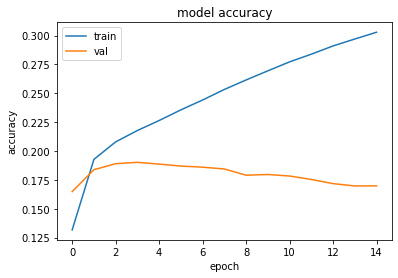

In [17]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
def generate_seq(model, proc, n_words, seed_text):
    in_text = seed_text
    for _ in range(n_words):
        vec = proc.transform([in_text])[:,1:]
        index = np.argmax(model.predict(vec, verbose=0), axis=1)[0]
        out_word = ''
        if index == 1:
            out_word = '_unk_'
        else:
            out_word = proc.id2token[index]
        in_text += ' ' + out_word
    return in_text

In [19]:
generate_seq(model, proc, max_length, 'cold')

'cold cucumber salad with yogurt dressing and lemon dressing number ww'

In [20]:
embedding_model = Model(inputs=model.inputs, outputs=model.layers[-3].output)
import tensorflow as tf
# import tensorflow_hub as hub

#using goolge embeddings
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [21]:
# embedding_model = embed(Model(inputs=model.inputs, outputs=model.layers[-3].output))

In [22]:
input_sequence = test_docs[random.randint(0, len(test_docs))]
print('input sequence: ', input_sequence, '\n\nhidden states:\n')
vec = proc.transform([input_sequence])[:,1:]
embedding_model.predict(vec)

input sequence:  baked fries 

hidden states:



array([[[ 0.0000000e+00, -1.6753142e-01,  0.0000000e+00, ...,
          8.4305227e-02,  0.0000000e+00, -3.9180142e-01],
        [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
          1.1257352e-01,  0.0000000e+00, -5.2518266e-01],
        [ 6.0072890e-03, -0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  8.3889849e-03, -1.6317239e-01],
        ...,
        [ 4.3171219e-04, -0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -1.7035214e-02,  0.0000000e+00, ...,
          8.9776851e-02, -4.4845566e-01, -6.7541851e-03],
        [-7.6158559e-01, -0.0000000e+00, -0.0000000e+00, ...,
          6.4579231e-01,  1.5644409e-01, -0.0000000e+00]]], dtype=float32)

In [23]:
test_vecs = proc.transform(test_docs)

In [24]:
hidden_states = embedding_model.predict(test_vecs[:, 1:])

In [25]:
mean_vecs = np.mean(hidden_states, axis=1)
max_vecs = np.max(hidden_states, axis=1)
sum_vecs = np.sum(hidden_states, axis=1)

In [26]:
dimension = hidden_states.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(sum_vecs):
    index.add_item(i, v)
index.build(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [27]:
input_sequence = test_docs[random.randint(0, len(test_docs))]
print('Query: ', input_sequence)

vec = proc.transform([input_sequence])[:,1:]
vec = np.sum(embedding_model.predict(vec), axis=1)
ids, _ = index.get_nns_by_vector(vec.T, 10, include_distances=True)

print('\nSearch Results:')
[test_docs[i] for i in ids][1:]

Query:  rice with pigeon peas arroz con gandules

Search Results:


['brown rice and pigeon peas arroz con gandules',
 'brown rice with fried bananas from angola',
 'easy sushi rice in rice cooker',
 'stir fried rice noodles with black bean sauce',
 'coconut lentils and rice arroz con lentejas y coco',
 'mock liver pt green beans',
 'black eyed peas and tomatoes with sauteed plantains or bananas',
 'basmati rice with carrots raisins and spices kabli',
 'low fat rice with peas carrots kosher pareve']

In [28]:
source_proc = processor(heuristic_pct_padding=.95, keep_n=50000)
source_vecs = source_proc.fit_transform(source_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [29]:
target_proc = processor(append_indicators=True, heuristic_pct_padding=.95, keep_n=12000, padding ='post')
target_vecs = target_proc.fit_transform(target_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [30]:
encoder_input_data = source_vecs
encoder_seq_len = encoder_input_data.shape[1]

decoder_input_data = target_vecs[:, :-1]
decoder_target_data = target_vecs[:, 1:]

num_encoder_tokens = max(source_proc.id2token.keys()) + 1
num_decoder_tokens = max(target_proc.id2token.keys()) + 1

In [31]:
#Create encoder

In [32]:
word_emb_dim=512
hidden_state_dim=1024
encoder_seq_len=encoder_seq_len
num_encoder_tokens=num_encoder_tokens
num_decoder_tokens=num_decoder_tokens

encoder_inputs = Input(shape=(encoder_seq_len,), name='Encoder-Input')
x = Embedding(num_encoder_tokens, word_emb_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)
_, state_h = GRU(hidden_state_dim, return_state=True, name='Encoder-Last-GRU', dropout=.5)(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [33]:
encoder_model.summary()

Model: "Encoder-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   [(None, 30)]              0         
_________________________________________________________________
Body-Word-Embedding (Embeddi (None, 30, 512)           2163712   
_________________________________________________________________
Encoder-Batchnorm-1 (BatchNo (None, 30, 512)           2048      
_________________________________________________________________
Encoder-Last-GRU (GRU)       [(None, 1024), (None, 102 4721664   
Total params: 6,887,424
Trainable params: 6,886,400
Non-trainable params: 1,024
_________________________________________________________________


In [34]:
decoder_inputs = Input(shape=(None,), name='Decoder-Input')
dec_emb = Embedding(num_decoder_tokens, word_emb_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)
decoder_gru = GRU(hidden_state_dim, return_state=True, return_sequences=True, name='Decoder-GRU', dropout=.5)
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

In [35]:
seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [36]:
seq2seq_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 512)    6145024     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      [(None, 30)]         0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 512)    2048        Decoder-Word-Embedding[0][0]     
____________________________________________________________________________________________

In [37]:
batch_size = 512
epochs = 15
#i upped the learning rate by x10,see how that works, its at 21% acc at epoch 5 elsewise
seq2seq_model.compile(optimizer=optimizers.Nadam(lr=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.1)

Train on 208472 samples, validate on 23164 samples
Epoch 1/15
208472/208472 [==============================] - 83s 397us/sample - loss: 2.4736 - acc: 0.6144 - val_loss: 7.2896 - val_acc: 0.1561
Epoch 2/15
208472/208472 [==============================] - 81s 391us/sample - loss: 1.7179 - acc: 0.6753 - val_loss: 2.3309 - val_acc: 0.6334
Epoch 3/15
208472/208472 [==============================] - 84s 402us/sample - loss: 1.5006 - acc: 0.6946 - val_loss: 2.3253 - val_acc: 0.6398
Epoch 4/15
208472/208472 [==============================] - 83s 400us/sample - loss: 1.3478 - acc: 0.7106 - val_loss: 2.3679 - val_acc: 0.6393
Epoch 5/15
208472/208472 [==============================] - 83s 399us/sample - loss: 1.2241 - acc: 0.7261 - val_loss: 2.4192 - val_acc: 0.6403
Epoch 6/15
208472/208472 [==============================] - 84s 401us/sample - loss: 1.1208 - acc: 0.7410 - val_loss: 2.4903 - val_acc: 0.6370
Epoch 7/15
208472/208472 [==============================] - 82s 392us/sample - loss: 1.0330

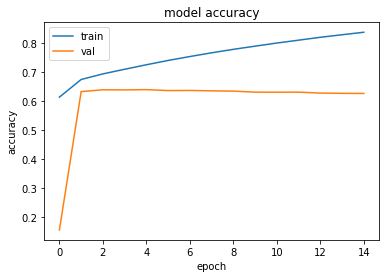

In [38]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
# !wget https://storage.googleapis.com/kdd-seq2seq-2018/kdd_seq2seq_weights.h5

In [40]:
# seq2seq_model.load_weights('kdd_seq2seq_weights.h5')

In [41]:
def extract_decoder_model(model):
    latent_dim = model.get_layer('Encoder-Model').output_shape[-1]
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input], [dense_out, gru_state_out])
    return decoder_model

In [42]:
encoder_model = seq2seq_model.get_layer('Encoder-Model')
for layer in encoder_model.layers:
    layer.trainable = False

decoder_model = extract_decoder_model(seq2seq_model)
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 512)    6145024     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 512)    2048        Decoder-Word-Embedding[1][0]     
__________________________________________________________________________________________________
hidden_state_input (InputLayer) [(None, 1024)]       0                                            
____________________________________________________________________________________________

In [43]:
i = random.randint(0, len(test_source_docs))

max_len = target_proc.padding_maxlen
raw_input_text = test_source_docs[i]

raw_tokenized = source_proc.transform([raw_input_text])
encoding = encoder_model.predict(raw_tokenized)
original_encoding = encoding
state_value = np.array(target_proc.token2id['_start_']).reshape(1, 1)

decoded_sentence = []
stop_condition = False
while not stop_condition:
    preds, st = decoder_model.predict([state_value, encoding])
    pred_idx = np.argmax(preds[:, :, 2:]) + 2
    pred_word_str = target_proc.id2token[pred_idx]

    if pred_word_str == '_end_' or len(decoded_sentence) >= max_len:
        stop_condition = True
        break
    decoded_sentence.append(pred_word_str)

    # update the decoder for the next word
    encoding = st
    state_value = np.array(pred_idx).reshape(1, 1)

print('sample code from test set:\n------------------------\n', raw_input_text)
print('\nground truth:\n------------------------\n', test_target_docs[i])
print('\npredicted description:\n------------------------')
print(' '.join(decoded_sentence))

sample code from test set:
------------------------
 dried navy beans, water, onion, bacon, brown sugar, molasses, tomato paste, salt, dry mustard, pepper

ground truth:
------------------------
 crock pot baked beans from scratch

predicted description:
------------------------
baked beans in crock pot


In [44]:
#generate embeddings

In [45]:
train_source_emb = encoder_model.predict(source_proc.transform(source_docs))

In [46]:
train_target_vecs = proc.transform(target_docs)
hidden_states = embedding_model.predict(train_target_vecs[:, 1:])

In [47]:
mean_vecs = np.mean(hidden_states, axis=1)
max_vecs = np.max(hidden_states, axis=1)
sum_vecs = np.sum(hidden_states, axis=1)
# train_target_emb = mean_vecs
train_target_emb = max_vecs

In [48]:
print('source embedding shape on training set: ', train_source_emb.shape)
print('target embedding shape on training set: ', train_target_emb.shape)

source embedding shape on training set:  (231636, 1024)
target embedding shape on training set:  (231636, 256)


In [49]:
dimension = hidden_states.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(sum_vecs):
    index.add_item(i, v)
index.build(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [50]:
#create joint vector space for embeddings

In [51]:
inp = Input(shape=(train_source_emb.shape[1],))
x = Dense(train_target_emb.shape[1], use_bias=False)(inp)
# x = BatchNormalization()(x)
# x = Dense(train_target_emb.shape[1])(x)
modal_model = Model([inp], x)
modal_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262144    
Total params: 262,144
Trainable params: 262,144
Non-trainable params: 0
_________________________________________________________________


In [52]:
modal_model.compile(optimizer=optimizers.Nadam(lr=2), loss='cosine_proximity', metrics=['accuracy'])

batch_size = 512
epochs = 50
history = modal_model.fit([train_source_emb], train_target_emb,
                          batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 208472 samples, validate on 23164 samples
Epoch 1/50
208472/208472 [==============================] - 3s 16us/sample - loss: -0.8018 - acc: 9.5936e-06 - val_loss: -0.8155 - val_acc: 0.0000e+00
Epoch 2/50
208472/208472 [==============================] - 3s 16us/sample - loss: -0.8272 - acc: 9.5936e-06 - val_loss: -0.8179 - val_acc: 0.0000e+00
Epoch 3/50
208472/208472 [==============================] - 3s 15us/sample - loss: -0.8300 - acc: 2.3984e-05 - val_loss: -0.8186 - val_acc: 0.0000e+00
Epoch 4/50
208472/208472 [==============================] - 3s 14us/sample - loss: -0.8314 - acc: 1.9187e-05 - val_loss: -0.8190 - val_acc: 0.0000e+00
Epoch 5/50
208472/208472 [==============================] - 3s 15us/sample - loss: -0.8323 - acc: 4.7968e-06 - val_loss: -0.8191 - val_acc: 4.3170e-05
Epoch 6/50
208472/208472 [==============================] - 3s 15us/sample - loss: -0.8328 - acc: 9.5936e-06 - val_loss: -0.8191 - val_acc: 8.6341e-05
Epoch 7/50
208472/208472 [=================

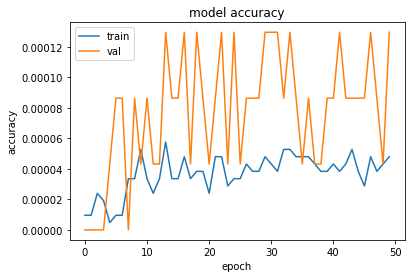

In [53]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
vec_code = modal_model.predict(encoder_model.predict(source_proc.transform(source_docs)))
vec_code.shape

(231636, 256)

In [55]:
#all code in a search box
dimension = vec_code.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(vec_code):
    index.add_item(i, v)
index.build(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  This is separate from the ipykernel package so we can avoid doing imports until


True

In [56]:
def vectorize_string(txt):
  vec = proc.transform([txt])[:,1:]
  emb = np.mean(embedding_model.predict(vec), axis=1)
  return emb

In [57]:
def search(inp):
  inp = vectorize_string(inp)
  ids, dist = index.get_nns_by_vector(inp.squeeze(), 5, include_distances=True)

  for i, dist in zip(ids, dist):
    print(f'dist: {dist:.2f}\n{source_docs[i]}\n')

In [58]:
# search('read csv file into pandas dataframe')

In [59]:
 search('chicken pot pie')

dist: 1.56
cake flour, bread flour, baking soda, baking powder, kosher salt, unsalted butter, light brown sugar, granulated sugar, eggs, pure vanilla extract, bittersweet chocolate chips, salt

dist: 1.57
flour, cocoa, baking powder, baking soda, butter, shortening, sugar, brown sugar, eggs, vanilla, chocolate chips, peanut butter

dist: 1.57
all-purpose flour, whole wheat flour, baking soda, cinnamon, salt, unsalted butter, unsweetened applesauce, honey, dark brown sugar, granulated sugar, peanut butter, egg, vanilla extract, semi-sweet chocolate chips

dist: 1.57
cake flour, bread flour, baking soda, baking powder, coarse salt, unsalted butter, light brown sugar, granulated sugar, eggs, vanilla extract, bittersweet chocolate, sea salt

dist: 1.57
gluten-free flour, xanthan gum, baking soda, salt, cocoa powder, butter, crisco, brown sugar, sugar, vanilla, eggs, mint chips



In [60]:
 search('iced tea')

dist: 1.49
butter, all-purpose flour, milk, chicken broth, mozzarella cheese, parmesan cheese, salt, fresh ground pepper, pasta, broccoli florets, cooked chicken, blue cheese

dist: 1.49
penne pasta, alfredo sauce, cheese, broccoli, boneless skinless chicken breasts

dist: 1.50
boneless skinless chicken breasts, penne pasta, frozen broccoli, mozzarella cheese, alfredo sauce, salt and pepper

dist: 1.50
fettuccine, broccoli, butter, boneless skinless chicken breast, condensed cream of mushroom soup, milk, parmesan cheese, fresh ground pepper

dist: 1.50
olive oil, boneless chicken breasts, garlic cloves, salt and pepper, broccoli florets, ziti pasta, half-and-half, fresh parmesan cheese, unsalted butter, dried red pepper flakes, water



In [61]:
 search('chocolate chip cookie')

dist: 1.47
olive oil, asparagus spear, salt, pepper, orzo pasta, fresh parsley, unsalted butter, jumbo shrimp, garlic, fresh lemon juice, black pepper

dist: 1.47
pasta, olive oil, butter, shallots, asparagus, garlic, fresh dill, medium shrimp, extra virgin olive oil, salt, fresh ground black pepper

dist: 1.47
jumbo shrimp, salt & freshly ground black pepper, olive oil, fennel bulb, garlic cloves, crushed red pepper flakes, orzo pasta, chickpeas, cherry tomatoes, kalamata olive, dill, lemon, zest of, dry white wine, low sodium chicken broth, feta

dist: 1.47
potatoes, extra virgin olive oil, kosher salt, cayenne pepper, shrimp, lemon zest, black pepper, garlic cloves, prosciutto, parsley

dist: 1.48
fusilli, olive oil, garlic clove, fresh spinach, asparagus, asiago cheese, parmesan cheese, salt, fresh ground black pepper

